In [1]:
import numpy as np
from time import time
import random 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics.pairwise import rbf_kernel,polynomial_kernel, sigmoid_kernel, laplacian_kernel, linear_kernel
from sklearn.metrics import accuracy_score

In [81]:
#fourclass dataset

data = load_svmlight_file("fourclass_scale")
x1 = data[0].toarray()
y1 = data[1]
y1[np.where(y1==-1)] = 0

In [93]:
#add noise
randidxneg = np.random.choice(np.where(y1==0)[0],30)
randidxpos = np.random.choice(np.where(y1==1)[0],20)

y1[randidxneg] = 1
y1[randidxpos] = 0

ValueError: 'a' cannot be empty unless no samples are taken

In [94]:
#breast cancer dataset

data2 = load_svmlight_file("breast-cancer_scale")
x2 = data2[0].toarray()
y2 = data2[1]
y2[np.where(y2==2)] = 0
y2[np.where(y2==4)] = 1

In [95]:
#add noise
randidxneg = np.random.choice(np.where(y2==0)[0],30)
randidxpos = np.random.choice(np.where(y2==1)[0],20)

y2[randidxneg] = 1
y2[randidxpos] = 0

In [23]:
from sklearn.manifold import TSNE
xt = TSNE(2).fit_transform(x2)
#plt.scatter(xt[:,0],xt[:,1],c=y2)
#plt.savefig("noise breastcancer", bbox_inches='tight',dpi = 200)

In [97]:
#lasvm code using kernels 

class lasvm():
    def __init__(self,kernel_name="RBF",gamma=1,C=1,tau=0.01):
        self.S = []
        self.a = []
        self.b = 0
        self.C = C
        self.tau = tau
        self.g = []
        self.y = []
        self.delta = 0
        self.i = 0
        self.maxiter = 5
        self.kernel_name = kernel_name
        self.gamma = gamma
        

    def kernel(self,a,b):
        if self.kernel_name == "RBF":
            return rbf_kernel(a,b,gamma=1.5)
        elif self.kernel_name == "Sigmoid":
            return sigmoid_kernel(a,b,gamma=0.0001)
        elif self.kernel_name == "Laplacian":
            return laplacian_kernel(a,b,gamma=1)
        elif self.kernel_name == "Linear":
            return linear_kernel(a,b)


    def A(self, i):
        return min(0,self.C*self.y[i])
    
    def B(self, i):
        return max(0,self.C*self.y[i])

    def tau_violating(self, i, j):
        return ((self.a[i] < self.B(i)) and
                (self.a[j] > self.A(j)) and
                (self.g[i] - self.g[j] > self.tau))

    def new_ij(self):
        S = self.S
        i = np.argmax(list((self.g[i] if self.a[i]<self.B(i) else -np.inf)
                           for i in range(len(S))))
        j = np.argmin(list((self.g[i] if self.a[i]>self.A(i) else np.inf)
                           for i in range(len(S))))
        return i,j

    def lambdaa(self, i, j):
        S = self.S
        si = S[i].reshape(1,-1)
        sj = S[j].reshape(1,-1)
        l = min(self.g[i]-self.g[j]/
            (self.kernel(si,si)+self.kernel(sj,sj)
                -2*(self.kernel(si,sj))),
            self.B(i)-self.a[i],self.a[j]-self.A(j))
    
        self.a[i]+=l
        self.a[j]-=l
        for s in range(len(S)):
            ss = S[s].reshape(1,-1)
            iis = self.kernel(si,ss)
            jjs = self.kernel(sj,ss)
            lijs = l*(iis - jjs)
            self.g[s] = self.g[s] - lijs
        return l

    
    def process(self, x, y):
        self.S.append(x)
        self.a.append(0)
        self.y.append(y)
        sv = self.kernel(self.S,x.reshape(1,-1))
        self.g.append(y - np.sign(np.dot(self.a,sv)))
        if y > 0:
            i = len(self.S)-1
            ii, j = self.new_ij()
        else:
            j = len(self.S)-1
            i, ii = self.new_ij()
        if not self.tau_violating(i, j): return
        S = self.S
        lambdaa = self.lambdaa(i,j)

    def reprocess(self):
        S = self.S
        i,j = self.new_ij()
        if not self.tau_violating(i,j): return
        lambdaa = self.lambdaa(i,j)
        i,j = self.new_ij()
        to_remove = []
        for s in range(len(S)):
            if self.a[s] < 0:
                to_remove.append(s)
        for s in reversed(to_remove):
            del S[s]
            del self.a[s]
            del self.y[s]
            del self.g[s]
        i,j = self.new_ij()
        self.b = (self.g[i]+self.g[j])/2.
        self.delta = self.g[i]-self.g[j]
                
    
    def update(self,X,y):
        random.seed(69)
        n_sample = X.shape[0]
        y[y==0] = -1
        i = 0
        
        while i <= self.maxiter:
            rand = random.randint(0,n_sample-1)
            while(any(np.array_equal(X[rand,:],x) for x in self.S)):
                rand = random.randint(0,n_sample-1)
                i = i+1
            self.process(X[rand,:],y[rand])
            self.reprocess()
            i = i+1
        while self.delta > self.tau:
            self.reprocess()
            
    def predict(self,X):
        predictions = np.array([])
        for j in range(X.shape[0]):
            sv = self.kernel(self.S,X[j,:].reshape(1,-1))
            y_pred = np.sign(np.dot(self.a,sv))
            predictions = np.append(predictions,y_pred)
        y_pred = predictions
        return y_pred
    

In [74]:
methods = ["Linear",
           "RBF", 
           "Sigmoid",
          "Laplacian"]
datasets = ["Fourclass","BreastCancer"]
timedf = pd.DataFrame(index=datasets,columns=methods)
accdf = pd.DataFrame(index=datasets,columns=methods)

In [ ]:
#rbf 1, 1.5
#sigmoid 2, 0.0001
# lap 1, 1

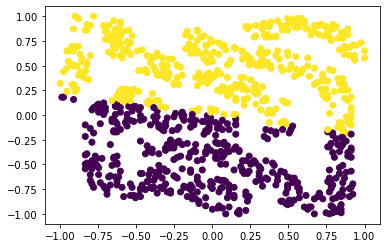

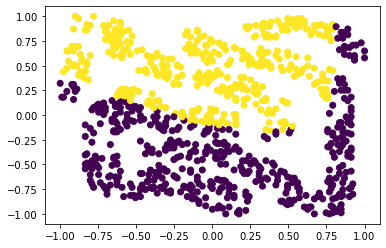

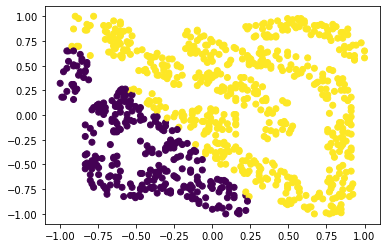

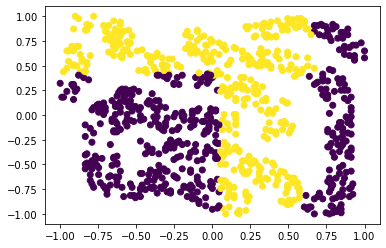

In [89]:
#fourclass
for i in methods:
    t0 = time()
    clf = lasvm(i)
    clf.update(x1,y1)
    labels = clf.predict(x1)
    t1 = time()
    timedf.loc["Fourclass",i] = t1-t0
    accdf.loc["Fourclass",i] = accuracy_score(labels,y1)*100
    plt.figure()
    plt.scatter(x1[:,0],x1[:,1],c=labels)
    plt.savefig("noise fourclass "+i, bbox_inches='tight',dpi = 200)

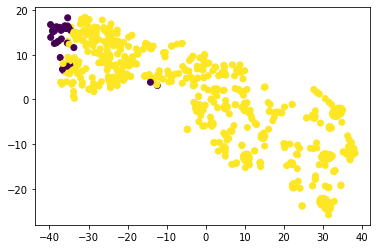

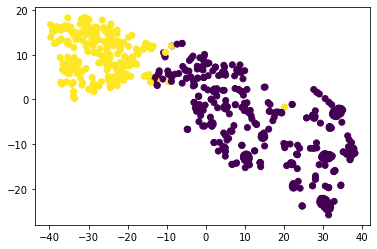

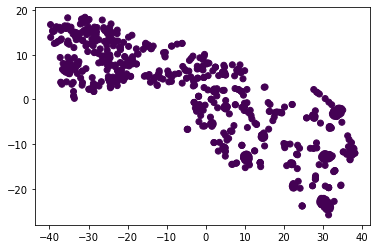

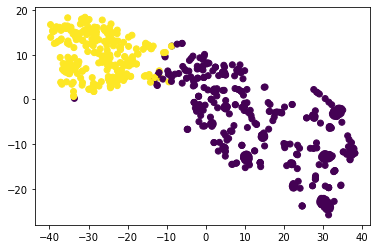

In [98]:
#breast cancer
for i in methods:
    t0 = time()
    clf = lasvm(i)
    clf.update(x2,y2)
    labels = clf.predict(x2)
    t1 = time()
    timedf.loc["BreastCancer",i] = t1-t0
    accdf.loc["BreastCancer",i] = accuracy_score(labels,y2)*100
    plt.figure()
    plt.scatter(xt[:,0],xt[:,1],c=labels)
    plt.savefig("noisy BreastCancer "+i, bbox_inches='tight',dpi = 200)

In [66]:
accdf

,Linear,RBF,Sigmoid,Laplacian
Fourclass,44.4316,41.5313,60.9049,54.1763
BreastCancer,30.6003,95.754,34.9927,96.1933


In [99]:
accdf

,Linear,RBF,Sigmoid,Laplacian
Fourclass,44.8956,43.1555,59.0487,53.0162
BreastCancer,32.6501,90.1903,36.4568,90.6296


In [67]:
timedf

,Linear,RBF,Sigmoid,Laplacian
Fourclass,0.0925312,0.172255,0.100731,0.146476
BreastCancer,0.0738595,0.140591,0.0688188,0.127631


In [100]:
timedf

,Linear,RBF,Sigmoid,Laplacian
Fourclass,0.085489,0.16057,0.0977402,0.161567
BreastCancer,0.0828123,0.124969,0.0890343,0.134639
